<a href="https://colab.research.google.com/github/gilbert-yy/FasionMNIST_MLP/blob/main/FasionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Original Implementation**

## 1.1 Network:

- 2 convolutional layers (with ReLU nonlinearity);
- 2 fully connected layers (with ReLU nonlinearity);
- 1 linear output layer


In [ ]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]


class FashionCNN(nn.Module):   
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*6*6, out_features=600),
            nn.ReLU()
        )
#        self.drop = nn.Dropout(0.25)
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=600, out_features=10),
            nn.ReLU()
        )
        
        self.fc3 = nn.Linear(in_features=10, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
#        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out



## 1.2 Dataset loading and train-test split
- **Train-test split: 50-50**

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

full_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
            transforms.Compose([transforms.ToTensor()]))

train_set, test_set = torch.utils.data.random_split(full_set, [int(len(full_set)/2), int(len(full_set)/2)])


Device cpu


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## 1.3 Free parameters

- imsizesq = 28
- num_classes = 10
- batch = 100
- num_epochs = 10 # change here!!!!
- learning_rate = 0.001

In [ ]:
# Parameter 1
imsizesq = 28
num_classes = 10
batch = 100
num_epochs = 10 # change here!!!!
learning_rate = 0.001

N_training = len(train_set)
N_test = len(test_set)
batch_Num_training = int(N_training/batch)
batch_Num_test = int(N_test/batch)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch)

## 1.4 Training and plotting

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=600, out_features=10, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=10, out_features=10, bias=True)
)
Epoch: 0, Loss: 0.2263353, Training Accuracy 0.8010; Test Accuracy 0.9100
Epoch: 1, Loss: 0.1852151, Training Accuracy 0.8884; Test Accuracy 0.9500
Epoch

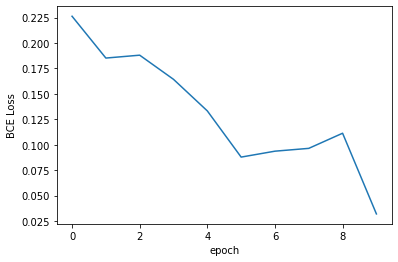

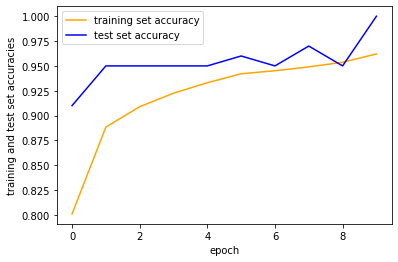

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = FashionCNN()
model.to(device)
model.fc2.register_forward_hook(get_activation('fc2'))
model.fc1.register_forward_hook(get_activation('fc1'))
model.layer2.register_forward_hook(get_activation('layer2'))

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

loss_hist = np.zeros(num_epochs)
accuracy_hist = np.zeros(num_epochs)
accuracy_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = images.view(batch, 1, imsizesq, imsizesq)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()


        is_correct = torch.max(outputs, 1)[1] == labels
        accuracy_hist[epoch] += is_correct.sum()/N_training

    loss_hist[epoch] = loss.data
    

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = images
        outputs = model(test)
        isCorrect = torch.max(outputs, 1)[1] == labels

        accuracy_test_hist[epoch] += is_correct.sum()/N_test
        
        
    print("Epoch: {}, Loss: {:.7f}, Training Accuracy {:.4f}; Test Accuracy {:.4f}".format(epoch, loss.data, accuracy_hist[epoch], accuracy_test_hist[epoch]))



class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = images
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(batch):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1

# Saving the fc2 layer outputs
images_train = []
train_data_labels = []
output_train_layer2= []
output_train_fc1 = []
output_train_fc2 = []
for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = images.view(batch, 1, imsizesq, imsizesq)
        train_data_labels.append(labels)
        outputs = model(train)

        images_train.append(images)
        output_train_layer2.append(activation["layer2"])
        output_train_fc1.append(activation["fc1"])
        output_train_fc2.append(activation["fc2"])

print("Test Set Accuracy")      
for i in range(num_classes):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))



images_test = []
test_data_labels = []
output_test_layer2= []
output_test_fc1 = []
output_test_fc2 = []
for images, labels in test_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        train = images.view(batch, 1, imsizesq, imsizesq)
        outputs = model(train)
        test_data_labels.append(labels)
        
        images_test.append(images)
        output_test_layer2.append(activation["layer2"])
        output_test_fc1.append(activation["fc1"])
        output_test_fc2.append(activation["fc2"])



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("BCE Loss")
plt.show()     

plt.figure()
plt.plot(accuracy_hist, label="training set accuracy", color = "orange")
plt.plot(accuracy_test_hist, label="test set accuracy", color = "blue")
plt.xlabel("epoch")
plt.ylabel("training and test set accuracies")
plt.legend()
plt.show()

# 1.5. Play with the model architecture. Try a new network with **Tanh nonlinearity***; add an additional fc layer, and run everything again:


Device cuda:0
FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): Tanh()
  )
  (fc2): Sequential(
    (0): Linear(in_features=600, out_features=200, bias=True)
    (1): Tanh()
  )
  (fc3): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
    (1): Tanh()
  )
  (fc4): Linear(in_features=10, out_features=10, bias=True)
)
Epoch: 0, Loss: 0.7558125, Training 

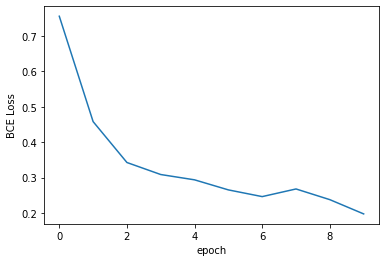

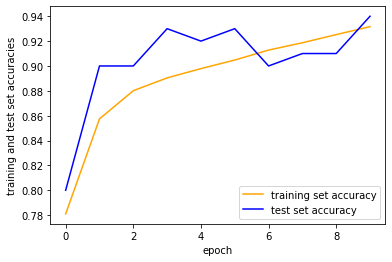

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]


class FashionCNN(nn.Module):   
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*6*6, out_features=600),
            nn.Tanh()
        )
#        self.drop = nn.Dropout(0.25)
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=600, out_features=200),
            nn.Tanh()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=200, out_features=10),
            nn.Tanh()
        )
        self.fc4 = nn.Linear(in_features=10, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
#        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

full_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
            transforms.Compose([transforms.ToTensor()]))

train_set, test_set = torch.utils.data.random_split(full_set, [int(len(full_set)/2), int(len(full_set)/2)])


# Parameter 1
imsizesq = 28
num_classes = 10
batch = 100
num_epochs = 10 # change here!!!!
learning_rate = 0.001

N_training = len(train_set)
N_test = len(test_set)
batch_Num_training = int(N_training/batch)
batch_Num_test = int(N_test/batch)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch)


model = FashionCNN()
model.to(device)
model.fc2.register_forward_hook(get_activation('fc2'))
model.fc1.register_forward_hook(get_activation('fc1'))
model.layer2.register_forward_hook(get_activation('layer2'))

error = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

loss_hist = np.zeros(num_epochs)
accuracy_hist = np.zeros(num_epochs)
accuracy_test_hist = np.zeros(num_epochs)

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = images.view(batch, 1, imsizesq, imsizesq)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()


        is_correct = torch.max(outputs, 1)[1] == labels
        accuracy_hist[epoch] += is_correct.sum()/N_training

    loss_hist[epoch] = loss.data
    

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = images
        outputs = model(test)
        isCorrect = torch.max(outputs, 1)[1] == labels

        accuracy_test_hist[epoch] += is_correct.sum()/N_test
        
        
    print("Epoch: {}, Loss: {:.7f}, Training Accuracy {:.4f}; Test Accuracy {:.4f}".format(epoch, loss.data, accuracy_hist[epoch], accuracy_test_hist[epoch]))



class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         test = images
#         outputs = model(test)
#         predicted = torch.max(outputs, 1)[1]
#         c = (predicted == labels).squeeze()
        
#         for i in range(batch):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             total_correct[label] += 1

# # Saving the fc2 layer outputs
# images_train = []
# output_train_layer2= []
# output_train_fc1 = []
# output_train_fc2 = []
# for images, labels in train_loader:
#         # Transfering images and labels to GPU if available
#         images, labels = images.to(device), labels.to(device)
#         train = images.view(batch, 1, imsizesq, imsizesq)
#         outputs = model(train)
#         images_train.append(images)
#         output_train_layer2.append(activation["layer2"])
#         output_train_fc1.append(activation["fc1"])
#         output_train_fc2.append(activation["fc2"])

# print("Test Set Accuracy")      
# for i in range(num_classes):
#     print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))



plt.figure()
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("BCE Loss")
plt.show()     

plt.figure()
plt.plot(accuracy_hist, label="training set accuracy", color = "orange")
plt.plot(accuracy_test_hist, label="test set accuracy", color = "blue")
plt.xlabel("epoch")
plt.ylabel("training and test set accuracies")
plt.legend()
plt.show()

Succeed. But the performance is not as good as the first one. Let's use the first architecture in the rest of the project.

# 2. SVM: A linear SVM applied 
1. directly on the input images;
2. to the output of the last convolutional layer (layer2 of the reference MLP);
3. to the output of the first fully connected layer (fc1);
4. to the output of the second fully connected layer (fc2);

In [ ]:
from sklearn import svm


In [ ]:
def loadData(train_data,train_label, test_data, test_label):
  mark = True
  for i in range(len(train_data)):
    images, labels = train_data[i], train_label[i]
    if mark:
      Input_train =  torch.flatten(images, start_dim=1)
      Input_train_y = torch.flatten(labels)
      mark = False
    else:
      Input_train  = torch.cat([Input_train, torch.flatten(images, start_dim=1)])
      Input_train_y = torch.cat([Input_train_y, torch.flatten(labels)])

  mark = True
  for i in range(len(test_data)):
    images, labels = test_data[i], test_label[i]
  # for images, labels in zip(test_data,test_label):
    if mark:
      Input_test =  torch.flatten(images, start_dim=1)
      Input_test_y = torch.flatten(labels)
      mark = False
    else:
      Input_test  = torch.cat([Input_test, torch.flatten(images, start_dim=1)])
      Input_test_y = torch.cat([Input_test_y, torch.flatten(labels)])

  return Input_train, Input_train_y, Input_test, Input_test_y



In [ ]:
# images_train = []
# train_data_labels = []
# output_train_layer2= []
# output_train_fc1 = []
# output_train_fc2 = []

## 2.1 SVM directly on the input images;

In [ ]:
Input_train, Input_train_y, Input_test, Input_test_y = loadData(images_train,train_data_labels, images_test, test_data_labels)

clf = svm.LinearSVC()
clf.fit(np.array(Input_train.cpu()), Input_train_y.cpu())

output = clf.predict(Input_train.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))

output = clf.predict(Input_test.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_test_y.cpu()
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training Accuracy is 0.8851
Test Accuracy is 0.8391


## 2.2 SVM to the output of the last convolutional layer (layer2 of the reference MLP);

In [ ]:
Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_layer2,train_data_labels, output_test_layer2, test_data_labels)

clf = svm.LinearSVC()
clf.fit(np.array(Input_train.cpu()), Input_train_y.cpu())

output = clf.predict(Input_train.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))

output = clf.predict(Input_test.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_test_y.cpu()
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training Accuracy is 0.9989
Test Accuracy is 0.8860


## 2.3 SVM to the output of the first fully connected layer (fc1);

In [ ]:
Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_fc1,train_data_labels, output_test_fc1, test_data_labels)

clf = svm.LinearSVC()
clf.fit(np.array(Input_train.cpu()), Input_train_y.cpu())

output = clf.predict(Input_train.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))

output = clf.predict(Input_test.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_test_y.cpu()
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Training Accuracy is 0.9792
Test Accuracy is 0.9099


## 2.4 to the output of the second fully connected layer (fc2);


In [ ]:
Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_fc2,train_data_labels, output_test_fc2, test_data_labels)

clf = svm.LinearSVC()
clf.fit(np.array(Input_train.cpu()), Input_train_y.cpu())

output = clf.predict(Input_train.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))

output = clf.predict(Input_test.cpu())
output = torch.from_numpy(output)
isCorrect = output == Input_test_y.cpu()
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

Training Accuracy is 0.9632
Test Accuracy is 0.9090


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# 3. Random forests applied:
1. directly on the input images;
2. to the output of the last convolutional layer (layer2 of the reference MLP);
3. to the output of the first fully connected layer (fc1);
4. to the output of the second fully connected layer (fc2); to the input images

## 3.1 Random forest directly on the input images;
The program takes long time to run, so further shrink the size of training data, making a train-test 10-90 split

In [ ]:
# images_train = []
# train_data_labels = []
# output_train_layer2= []
# output_train_fc1 = []
# output_train_fc2 = []

torch.Size([30000, 784])

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor


Input_train, Input_train_y, Input_test, Input_test_y = loadData(images_train,train_data_labels, images_test, test_data_labels)

Input_train, Input_train_y = Input_train[:3000], Input_train_y[:3000],
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 128)
rf.fit(Input_train.cpu(), Input_train_y.cpu())



# Use the forest's predict method on the test data
predictions = rf.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = rf.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))


Training Accuracy is 0.1250
Training Accuracy is 0.0803


## 3.2 Random forest to the output of the last convolutional layer (layer2 of the reference MLP);;
The program takes long time to run, so further shrink the size of training data, making a train-test 10-90 split

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor


Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_layer2,train_data_labels, output_test_layer2, test_data_labels)

# do a 10-90 split, for saving computational cost
Input_train, Input_train_y = Input_train[:3000], Input_train_y[:3000],
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 128)
rf.fit(Input_train.cpu(), Input_train_y.cpu())



# Use the forest's predict method on the test data
predictions = rf.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = rf.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))


Training Accuracy is 0.0810
Test Accuracy is 0.0339


## 3.3 Random forest to the output of the first fully connected layer (fc1);
The program takes long time to run, so further shrink the size of training data, making a train-test 10-90 split

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor


Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_fc1,train_data_labels, output_test_fc1, test_data_labels)

# do a 10-90 split, for saving computational cost
Input_train, Input_train_y = Input_train[:3000], Input_train_y[:3000],
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 128)
rf.fit(Input_train.cpu(), Input_train_y.cpu())



# Use the forest's predict method on the test data
predictions = rf.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = rf.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))


Training Accuracy is 0.3913
Test Accuracy is 0.3104


## 3.4 Random forest to the output of the second fully connected layer (fc2);
The program takes long time to run, so further shrink the size of training data, making a train-test 10-90 split

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor


Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_fc2,train_data_labels, output_test_fc2, test_data_labels)

# do a 10-90 split, for saving computational cost
Input_train, Input_train_y = Input_train[:3000], Input_train_y[:3000],
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 128)
rf.fit(Input_train.cpu(), Input_train_y.cpu())



# Use the forest's predict method on the test data
predictions = rf.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = rf.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))


Training Accuracy is 0.7037
Test Accuracy is 0.6302


# 4. Multi-class least squares applied to the input images (2.1) and three outputs detailed in 2.2, 2.3
and 2.4.

## 4.1 Multi-class least squares directly on the input images;

In [ ]:
# images_train = []
# train_data_labels = []
# output_train_layer2= []
# output_train_fc1 = []
# output_train_fc2 = []

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


Input_train, Input_train_y, Input_test, Input_test_y = loadData(images_train,train_data_labels, images_test, test_data_labels)

lda = LDA(n_components=1)
lda.fit(Input_train.cpu(),Input_train_y.cpu())


# Use the forest's predict method on the test data
predictions = lda.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = lda.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

Training Accuracy is 0.8382
Test Accuracy is 0.8223


## 4.2 Multi-class least squares  to the output of the last convolutional layer (layer2 of the reference MLP);

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_layer2,train_data_labels, output_test_layer2, test_data_labels)

lda = LDA(n_components=1)
lda.fit(Input_train.cpu(),Input_train_y.cpu())


# Use the forest's predict method on the test data
predictions = lda.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = lda.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

Training Accuracy is 0.9399
Test Accuracy is 0.9067


## 4.3 Multi-class least squares to the output of the first fully connected layer (fc1);

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_fc1,train_data_labels, output_test_fc1, test_data_labels)

lda = LDA(n_components=1)
lda.fit(Input_train.cpu(),Input_train_y.cpu())


# Use the forest's predict method on the test data
predictions = lda.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = lda.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

Training Accuracy is 0.9598
Test Accuracy is 0.9146


## 4.4 Multi-class least squares to the output of the second fully connected layer (fc2);

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


Input_train, Input_train_y, Input_test, Input_test_y = loadData(output_train_fc2,train_data_labels, output_test_fc2, test_data_labels)

lda = LDA(n_components=1)
lda.fit(Input_train.cpu(),Input_train_y.cpu())


# Use the forest's predict method on the test data
predictions = lda.predict(Input_train.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_train_y.cpu()
print('Training Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_train_y)))


# Use the forest's predict method on the test data
predictions = lda.predict(Input_test.cpu())
predictions = torch.from_numpy(predictions)
isCorrect = predictions == Input_test_y
print('Test Accuracy is {:.4f}'.format(isCorrect.sum()/len(Input_test_y)))

Training Accuracy is 0.9559
Test Accuracy is 0.9039


In [ ]:
output_train_fc2